In [2]:
%pylab inline
import glob
import sys
from collections import OrderedDict
import caffe
home = '/gpfs01/bethge/home/lgatys'
base_dir = home + '/caffe_projects/TextureModel/TextureSynthesis/PublicCode/DeepTextures/'
sys.path.append(base_dir)
from DeepImageSynthesis import *
VGGweights = base_dir + 'Models/VGG_normalised.caffemodel'
VGGmodel = base_dir + 'Models/VGG_ave_pool_deploy.prototxt'
imagenet_mean = array([ 0.40760392,  0.45795686,  0.48501961]) #mean for color channels (bgr)
im_dir = base_dir + 'Images/'
gpu = 0
caffe.set_mode_gpu() #for cpu mode do 'caffe.set_mode_cpu()'
caffe.set_device(gpu)

Populating the interactive namespace from numpy and matplotlib


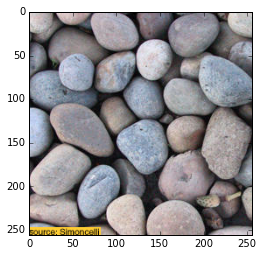

In [6]:
#load source image
source_img_name = glob.glob1(im_dir, 'pebbles.jpg')[0]
source_img_org = caffe.io.load_image(im_dir + source_img_name)
im_size = 256.
[source_img, net] = load_image(im_dir + source_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
im_size = asarray(source_img.shape[-2:])

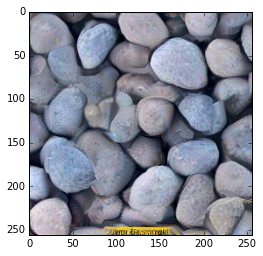

In [8]:
#l-bfgs parameters optimisation
maxiter = 2000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])
    
#get optimisation bounds
bounds = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints, bounds=bounds,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

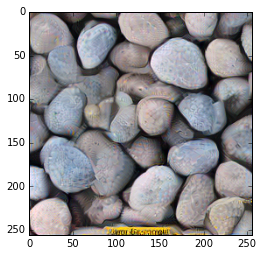

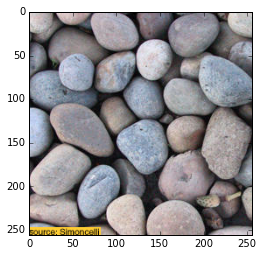

In [10]:
#match histogram of new texture with that of the source texture and show both images
new_texture = result['x'].reshape(*source_img.shape[1:]).transpose(1,2,0)[:,:,::-1]
new_texture = histogram_matching(new_texture, source_img_org)
imshow(new_texture)
figure()
imshow(source_img_org)